In [2]:
from datamarket import *

# Read the data and train model without augmentation
We first use factorized linear regression, then automl.

In summary, R2 score for linear regression is:0.009878592245889273, for automl is: 0.5458767724247864

In [3]:
# read buyer dataset
# gender 
buyer = pd.read_csv("gender.csv")
# ethnic 
# buyer = pd.read_csv("2013-2017_School_ELA_Results_-_Ethnic.csv")
# survery
# buyer = pd.read_csv("NH_SurveySummary_Mar2022.csv", encoding='cp1252')

# buyer = pd.read_csv("NH_CovidVaxProvider_20220320.csv", encoding='cp1252')

# train test split
msk = split_mask(len(buyer)) < 0.8
buyer_train = buyer[msk].copy()
buyer_test = buyer[~msk].copy()

In [152]:
buyer

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Inspection Cycle,Health Survey Date,Fire Safety Survey Date,Total Number of Health Deficiencies,...,Count of Interior Deficiencies,Count of Gas and Vacuum and Electrical Systems Deficiencies,Count of Hazardous Area Deficiencies,Count of Illumination and Emergency Power Deficiencies,Count of Laboratories Deficiencies,Count of Medical Gases and Anaesthetizing Areas Deficiencies,Count of Smoking Regulations Deficiencies,Count of Miscellaneous Deficiencies,Location,Processing Date
0,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,1,2019-08-21,2019-08-21,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"701 MONROE STREET NW,RUSSELLVILLE,AL,35653",2022-03-01
1,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2,2018-08-01,2018-08-09,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"701 MONROE STREET NW,RUSSELLVILLE,AL,35653",2022-03-01
2,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,3,2017-06-22,2017-06-29,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"701 MONROE STREET NW,RUSSELLVILLE,AL,35653",2022-03-01
3,015010,COOSA VALLEY HEALTHCARE CENTER,260 WEST WALNUT STREET,SYLACAUGA,AL,35150,1,2019-06-13,2019-06-18,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"260 WEST WALNUT STREET,SYLACAUGA,AL,35150",2022-03-01
4,015010,COOSA VALLEY HEALTHCARE CENTER,260 WEST WALNUT STREET,SYLACAUGA,AL,35150,2,2018-06-07,2018-06-11,4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"260 WEST WALNUT STREET,SYLACAUGA,AL,35150",2022-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45255,686124,HARMONY HEALTH CENTER,9820 N KENDALL DRIVE,MIAMI,FL,33176,1,2021-02-12,2021-02-16,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"9820 N KENDALL DRIVE,MIAMI,FL,33176",2022-03-01
45256,686124,HARMONY HEALTH CENTER,9820 N KENDALL DRIVE,MIAMI,FL,33176,2,2019-05-17,2019-05-15,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"9820 N KENDALL DRIVE,MIAMI,FL,33176",2022-03-01
45257,745000,LAS ALTURAS DE PENITAS,414 LIBERTY BLVD.,PENITAS,TX,78576,1,2021-07-08,2021-07-08,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"414 LIBERTY BLVD.,PENITAS,TX,78576",2022-03-01
45258,745001,ESTATES AT SHAVANO PARK,4366 LOCKHILL SELMA,SHAVANO PARK,TX,78249,1,2021-07-16,2021-07-16,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"4366 LOCKHILL SELMA,SHAVANO PARK,TX,78249",2022-03-01


In [4]:
buyer_train_data = agg_dataset()
buyer_train_data.load(buyer_train, ["Number Tested", "Mean Scale Score"], ["DBN", ["DBN","Grade"], "Year", "Category"], "buyer")
buyer_train_data.process_target("Mean Scale Score")
# buyer_train_data.load(buyer_train, ['Total Number of Health Deficiencies','Total Number of Fire Safety Deficiencies'], ["Federal Provider Number", 'Location', 'Processing Date'], "buyer")
# buyer_train_data.process_target('Total Number of Health Deficiencies')
# buyer_train_data.load(buyer_train, ['Percent Vaccinated Residents'], ["Federal Provider Number", 'Provider State'], "buyer")
# buyer_train_data.process_target('Percent Vaccinated Residents')
buyer_train_data.to_numeric_and_impute_all()
buyer_train_data.remove_redundant_columns()
buyer_train_data.compute_agg()

buyer_test_data = agg_dataset()
buyer_test_data.load(buyer_test, ["Number Tested", "Mean Scale Score"], ["DBN", ["DBN","Grade"], "Year", "Category"], "buyer")
buyer_test_data.process_target("Mean Scale Score")
# buyer_test_data.load(buyer_test, ['Total Number of Health Deficiencies','Total Number of Fire Safety Deficiencies'], ["Federal Provider Number", 'Location', 'Processing Date'], "buyer")
# buyer_test_data.process_target('Total Number of Health Deficiencies')
# buyer_test_data.load(buyer_test, ['Percent Vaccinated Residents'], ["Federal Provider Number", 'Provider State'], "buyer")
# buyer_test_data.process_target('Percent Vaccinated Residents')
buyer_test_data.to_numeric_and_impute_all()
buyer_test_data.remove_redundant_columns()
buyer_test_data.compute_agg()

In [5]:
# model performance before augmentation with linear regression
train_cov = buyer_train_data.covariance
test_cov = buyer_test_data.covariance
X = ['Number Tested']
y = 'Mean Scale Score'

# X = ['Total Number of Fire Safety Deficiencies']
# y = 'Total Number of Health Deficiencies'

# X = []
# y = 'Percent Vaccinated Residents'

parameter = linear_regression(train_cov, ["buyer:" + x for x in X], "buyer:" + y)
print("R2 score is:" + str(r2(test_cov, ["buyer:" + x for x in X], "buyer:" + y, parameter)))

R2 score is:0.007614738280170785


In [23]:
categories = ['DBN', 'Year', "Grade", "Category"]
# categories = ["Federal Provider Number", 'Location', 'Processing Date']
# categories = ["Federal Provider Number", 'Provider State']
for cate in categories:
    buyer = buyer.astype({cate: 'category'})

buyer[y] = pd.to_numeric(buyer[y], errors='coerce')
buyer.dropna(subset=[y],inplace=True)
msk = split_mask(len(buyer)) < 0.8
buyer_train = buyer[msk].copy()
buyer_test = buyer[~msk].copy()

In [31]:
time_budget = 600

In [136]:
%%time
# model performance with autoML 
X_train = buyer_train[X + categories]
y_train = buyer_train[y]
X_test = buyer_test[X + categories]
y_test = buyer_test[y]

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=time_budget,
    per_run_time_limit=int(time_budget/3),
    memory_limit=6072
)
automl.fit(X_train, y_train, X_test, y_test, dataset_name='buyer')

now_n = datetime.now()
current_time = now_n.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 01:15:17
CPU times: user 1.25 s, sys: 854 ms, total: 2.1 s
Wall time: 10min 2s


In [137]:
automl.sprint_statistics()

'auto-sklearn results:\n  Dataset name: buyer\n  Metric: r2\n  Best validation score: 0.119860\n  Number of target algorithm runs: 21\n  Number of successful target algorithm runs: 15\n  Number of crashed target algorithm runs: 2\n  Number of target algorithms that exceeded the time limit: 3\n  Number of target algorithms that exceeded the memory limit: 1\n'

Train R2 score: 0.10989946814293938
Test R2 score: 0.1251683564703593
          rank  ensemble_weight               type      cost  duration
model_id                                                              
4            1             0.52        extra_trees  0.880140  7.538252
19           2             0.48  gradient_boosting  0.880196  3.876652
                    Timestamp  ensemble_optimization_score  \
12 2022-04-04 01:05:30.000000                          NaN   
0  2022-04-04 01:05:30.449448                     0.096048   
13 2022-04-04 01:05:34.000000                     0.096048   
1  2022-04-04 01:05:34.134392                     0.107126   
14 2022-04-04 01:05:41.000000                     0.107126   
24 2022-04-04 01:05:41.000000                     0.107126   
23 2022-04-04 01:05:41.000000                     0.107126   
22 2022-04-04 01:05:41.000000                     0.107126   
21 2022-04-04 01:05:41.000000                     0.107126   
20 2022-04-04 01:05:41.000

<AxesSubplot:title={'center':'Auto-sklearn accuracy over time'}, xlabel='Timestamp'>

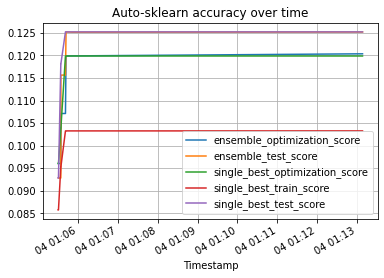

In [138]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print(automl.leaderboard())
poT = automl.performance_over_time_
print(poT)
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)

In [139]:
poT1 = automl.performance_over_time_

In [140]:
poT1 = automl.performance_over_time_
poT1["duration"] = [t.total_seconds() + time_budget for t in(poT1["Timestamp"] - now_n)]
# poT1[["ensemble_test_score", "duration"]]
poT1.fillna(0, inplace=True)
poT1[["ensemble_test_score", "duration"]].to_csv("automl_naive_vax.csv",index=False)

In [34]:
market_time = 120
poT2["duration"] = [t.total_seconds() + market_time + time_budget for t in(poT2["Timestamp"] - now_aug)]
poT2.fillna(0, inplace=True)
poT2[["ensemble_test_score", "duration"]].to_csv("automl_service_gender.csv",index=False)

In [ ]:
poT2

# Load seller datasets and build market
Currently, we need to specify the join attributes (could be joined on multiple attributes) and these attributes name have to be same across two tables.

We need more data.

The best data increase linear regression R2 to 0.3944023420421897

This data also increase automl R2 to: 0.7970338954417067

In [13]:
import json

with open("market_data.json", "w") as outfile:
    outfile.write(json.dumps(market_data))

In [14]:
with open('market_data.json', 'r') as openfile:
    market_data = json.load(openfile)

In [17]:
sellers = []

for data in market_data:
    file, dimension, name = data
    df = pd.read_csv(file)
    aggdata = agg_dataset()
    aggdata.load(df, [], dimension, name)
    aggdata.find_features()
    aggdata.remove_redundant_columns()
    aggdata.compute_agg(True)
    
    sellers.append((aggdata, dimension[0]))

/home/jupyter/arda/arda-datasets/school/datamarket.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.data['cov:Q:' + tablename + ":" + attributes[i] + ","+ tablename + ":" + attributes[j]] = self.data[attributes[i]] * self.data[attributes[j]]


In [16]:
# i = 317
# for file in files:
#     print("(\"other/" + file + "\", [\"DBN\"], " + "\"dm" + str(i)+ "\"),")
#     i += 1
#     file, dimension, name = ("other/" + file, ["DBN"], "dm38")

#     df = pd.read_csv(file)
#     aggdata = agg_dataset()
#     aggdata.load(df, [], dimension, name)
#     aggdata.find_features()
#     aggdata.remove_redundant_columns()
#     aggdata.compute_agg(True)

#     cur_atts, final_r2 = select_features(buyer_train_data, buyer_test_data, aggdata, dimension[0], 6, y)
    

In [72]:
%%time
cur_atts, final_r2 = select_features(buyer_train_data, buyer_test_data, aggdata, dimension[0], 6, y)
print(cur_atts, final_r2)

['buyer:Number Tested', 'dm36:Total Enrollment (Half Day & Full Day)', 'dm36:#Male', 'dm36:#Female'] 0.010862900128407404
CPU times: user 33.8 ms, sys: 4.48 ms, total: 38.3 ms
Wall time: 34.3 ms


/home/jupyter/arda/arda-datasets/school/datamarket.py:384: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  join.drop('cov:c_y', 1, inplace=True)


In [76]:
%%time
pd.merge(buyer_train_data.data, aggdata.data, left_on="DBN", right_on="DBN")
# cur_atts, final_r2 = select_features(buyer_train_data, buyer_test_data, aggdata, dimension[0], 6, y)
# print(cur_atts, final_r2)

CPU times: user 12.4 ms, sys: 4.14 ms, total: 16.6 ms
Wall time: 14.4 ms


,DBN,Grade,Year,Category,cov:s:buyer:Number Tested,cov:s:buyer:Mean Scale Score,cov:c_x,"cov:Q:buyer:Number Tested,buyer:Number Tested","cov:Q:buyer:Number Tested,buyer:Mean Scale Score","cov:Q:buyer:Mean Scale Score,buyer:Mean Scale Score",cov:s:dm36:Total Enrollment (Half Day & Full Day),cov:s:dm36:#Female,cov:s:dm36:#Male,cov:c_y,"cov:Q:dm36:Total Enrollment (Half Day & Full Day),dm36:Total Enrollment (Half Day & Full Day)","cov:Q:dm36:Total Enrollment (Half Day & Full Day),dm36:#Female","cov:Q:dm36:Total Enrollment (Half Day & Full Day),dm36:#Male","cov:Q:dm36:#Female,dm36:#Female","cov:Q:dm36:#Female,dm36:#Male","cov:Q:dm36:#Male,dm36:#Male"
0,01M015,3,2013,Female,12,285.0,1,144,3420.0,81225.0,17.0,10.0,7.0,1,289.0,170.0,119.0,100.0,70.0,49.0
1,01M015,3,2013,Male,15,292.0,1,225,4380.0,85264.0,17.0,10.0,7.0,1,289.0,170.0,119.0,100.0,70.0,49.0
2,01M015,3,2015,Female,7,289.0,1,49,2023.0,83521.0,17.0,10.0,7.0,1,289.0,170.0,119.0,100.0,70.0,49.0
3,01M015,3,2017,Female,13,308.0,1,169,4004.0,94864.0,17.0,10.0,7.0,1,289.0,170.0,119.0,100.0,70.0,49.0
4,01M015,4,2013,Female,12,283.0,1,144,3396.0,80089.0,17.0,10.0,7.0,1,289.0,170.0,119.0,100.0,70.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20807,32K384,All Grades,2013,Female,197,300.0,1,38809,59100.0,90000.0,27.0,11.0,16.0,1,729.0,297.0,432.0,121.0,176.0,256.0
20808,32K384,All Grades,2013,Male,186,294.0,1,34596,54684.0,86436.0,27.0,11.0,16.0,1,729.0,297.0,432.0,121.0,176.0,256.0
20809,32K384,All Grades,2014,Female,204,297.0,1,41616,60588.0,88209.0,27.0,11.0,16.0,1,729.0,297.0,432.0,121.0,176.0,256.0
20810,32K384,All Grades,2014,Male,193,290.0,1,37249,55970.0,84100.0,27.0,11.0,16.0,1,729.0,297.0,432.0,121.0,176.0,256.0


In [83]:
# provider = pd.read_csv("NH_ProviderInfo_Mar2022.csv",  encoding='cp1252')
# providerdata = agg_dataset()
# providerdata.load(provider, [], ["Federal Provider Number"], "provider")
# providerdata.find_features()
# providerdata.remove_redundant_columns()
# providerdata.create_count_true()
# providerdata.compute_agg(True)

# faclevel_2020 = pd.read_csv("faclevel2020.csv",  encoding='cp1252')
# facleveldata = agg_dataset()
# facleveldata.load(faclevel_2020, [], ["Federal Provider Number"], "faclevel")
# facleveldata.find_features()
# facleveldata.remove_redundant_columns()
# facleveldata.create_count_true()
# facleveldata.compute_agg(True)


# uscovid = pd.read_csv("covid-newcases_2021.csv")
# uscoviddata = agg_dataset()
# uscoviddata.load(uscovid, [], [["Week Ending", "Provider State"]], "uscovid")
# uscoviddata.find_features()
# uscoviddata.remove_redundant_columns()
# uscoviddata.create_count_true()
# uscoviddata.compute_agg(True)

# measure = pd.read_csv("measure_scale.csv")
# measuredata = agg_dataset()
# measuredata.load(measure, [], ["Measure Code"], "measure")
# measuredata.find_features()
# measuredata.remove_redundant_columns()
# measuredata.create_count_true()
# measuredata.compute_agg(True)


In [35]:
%%time
# sellers = [(crimedata, "DBN"), (apdata, "DBN"), (surveydata, "DBN"), 
#            (basedata, "DBN"), (discdata, "DBN"), (mathdata, "DBN"), 
#            (ossdata, "DBN"), (pedata, "DBN"), (s2trdata, "DBN"), 
#            (satdata, "DBN"), (prodata, "DBN"), (spydata, "Year"),
#            (transferdata, "DBN"), (yabcdata, "DBN"), (dm1data, "DBN"),
#            (dm2data, "DBN"), (dm3data, "DBN"), (dm4data, "DBN"), (dm5data, "DBN")]

# sellers = [(mathdata, ("DBN","Grade"))]
# sellers = [(providerdata, "Federal Provider Number")]

# find m best datasets to augment
# bought = set()
m = 3

for i in range(m):
    best_seller = None
    best_seller_attrs = []
    best_dimension = None
    best_r2 = 0

    for sellerdata, dimension in sellers:
        print(sellerdata.name)
#         pd.merge(buyer_train_data.data, sellerdata.data, left_on=dimension, right_on=dimension)
        # check if current seller has been bought
        if sellerdata.name in buyer_train_data.datasets:
            continue

        # find the attributes and r2 of augmenting
        cur_atts, final_r2 = select_features(buyer_train_data, buyer_test_data, sellerdata, dimension, 6, y)
#         cur_atts, final_r2 = select_features(buyer_train, buyer_test, sellerdata, dimension,10)
        print(cur_atts, final_r2)
        if final_r2 > best_r2:
            best_seller = sellerdata
            best_dimension = dimension
            best_seller_attrs = cur_atts
            best_r2 = final_r2


    print(best_seller.name, best_seller_attrs, best_r2)
    
    if len([x for x in best_seller_attrs if x in best_seller.X]) == 0:
        buyer_train_data.datasets.add(best_seller)
        buyer_test_data.datasets.add(best_seller)
    else:
        buyer_train_data.absorb(best_seller, best_dimension, best_seller_attrs + [buyer_train_data.name + ":" + y])
        buyer_test_data.absorb(best_seller, best_dimension, best_seller_attrs + [buyer_train_data.name + ":" + y])

disc
['disc:ADMINISTRATIVE DISTRICT', 'buyer:Number Tested', 'disc:SY1617 TOTAL REMOVALS/SUSPENSIONS'] 0.017979894036671884
esl


/home/jupyter/arda/arda-datasets/school/datamarket.py:384: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  join.drop('cov:c_y', 1, inplace=True)


['esl:Level 3+4 %', 'esl:Level 3 %', 'esl:Mean Scale Score', 'esl:Level 4 #', 'esl:Grade', 'esl:Level 2 #'] 0.4371102983229789
math
['math:Level 4 %', 'math:Level 1 %', 'math:Grade', 'math:Year', 'math:Mean Scale Score', 'math:Level 4 #'] 0.40258004318332297
oss
['oss:ADMINISTRATIVE DISTRICT', 'buyer:Number Tested'] 0.020088419463490492
pe
['pe:Student Enrollment', 'pe:Full Time Licensed PE Teachers', 'pe:Total Part Time and Full Time PE Teachers*', 'buyer:Number Tested', 'pe:Geographical District', 'pe:Admin District'] 0.112637821639341
s2tr
['s2tr:School Pupil-Teacher Ratio', 'buyer:Number Tested'] 0.21816653440794265
sat
['buyer:Number Tested', 'sat:Writing Mean', 'sat:Number of Test Takers', 'sat:Mathematics Mean'] 0.00918677833088355
pro
['pro:2012-2013 PERFORMANCE CATEGORY SCORE', 'pro:2012-2013 ADDITIONAL CREDIT', 'pro:DISTRICT', 'pro:2012-2013 PROGRESS CATEGORY SCORE', 'pro:2012-13 OVERALL PERCENTILE', 'pro:2012-2013 ENVIRONMENT CATEGORY SCORE'] 0.38489822321033296
transfer
['b

/home/jupyter/arda/arda-datasets/school/datamarket.py:417: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  join['cov:Q:' + att2 + "," + att1] = join['cov:s:' + att2] * join['cov:s:' + att1]


['buyer:Number Tested', 'dm118:ELA Unadjusted Growth Percentile (TRAN)', 'dm118:Peer 100% of Range 13', 'dm118:Peer Percent of Range 8', 'dm118:ELA Unadjusted Growth Percentile (STD)', 'dm118:Math % Level 3/4'] 0.007614738280339206
dm119
['dm119:ADMINISTRATIVE DISTRICT', 'buyer:Number Tested', 'dm119:SY1617 TOTAL REMOVALS/SUSPENSIONS'] 0.017979894036671884
dm120
['dm120:ADMINISTRATIVE DISTRICT', 'buyer:Number Tested'] 0.020088419463490492
dm121
['dm121:ADMINISTRATIVE DISTRICT', 'buyer:Number Tested'] 0.020088419463490492
dm122
['buyer:Number Tested'] 0.007614738280117828
dm123
['buyer:Number Tested'] 0.007614738280117828
dm124
['buyer:Number Tested', 'dm124:Grade level'] 0.016224666129449505
dm125
['dm125:ADMINISTRATIVE DISTRICT', 'buyer:Number Tested'] 0.020088419463490492
dm126
['buyer:Number Tested', 'dm126:Average Grade 8 Math Proficiency', 'dm126:Percent HRA Eligible', 'dm126:Enrollment', 'dm126:Strong Family-Community Ties - Percent Positive', 'dm126:Supportive Environment - Perc

In [55]:
best_dimension = ['DBN', 'Grade']

In [20]:
# make best_dimension a list
if isinstance(best_dimension, tuple):
    best_dimension = list(best_dimension)
else:
    best_dimension = [best_dimension]

# extract needed attributes
seller_features = ['cov:s:' +  attr for attr in best_seller_attrs  if attr.startswith(best_seller.name)]
buyer_features = ['cov:s:' +  attr for attr in best_seller_attrs  if not attr.startswith(best_seller.name)]
target = ['cov:s:buyer:' + y]
buyer_train_data_df = buyer_train_data.data[buyer_train_data.dedup_dimensions + buyer_features + target]
buyer_test_data_df = buyer_test_data.data[buyer_train_data.dedup_dimensions + buyer_features + target]
seller_data = best_seller.data[best_dimension + seller_features]
# seller_data = seller_data.groupby(best_dimension).mean()

# join buyer and seller
join_train = pd.merge(buyer_train_data_df,seller_data,how='left', on=best_dimension)
join_test = pd.merge(buyer_test_data_df,seller_data,how='left', on=best_dimension)

In [21]:
join_train

,Category,DBN,Year,Grade,cov:s:buyer:Mean Scale Score,cov:s:dm59:Average Grade 4 English Proficiency,cov:s:dm59:Economic Need Index,cov:s:dm59:Average Grade 4 Math Proficiency,cov:s:dm59:% ELL,cov:s:dm59:% Self-Contained,cov:s:dm59:Percent Black
0,Female,01M015,2013,3,285.0,2.13,1.33,2.13,0.116,0.030,0.384
1,Male,01M015,2013,3,292.0,2.13,1.33,2.13,0.116,0.030,0.384
2,Female,01M015,2015,3,289.0,2.13,1.33,2.13,0.116,0.030,0.384
3,Female,01M015,2017,3,308.0,2.13,1.33,2.13,0.116,0.030,0.384
4,Male,01M015,2017,3,297.0,2.13,1.33,2.13,0.116,0.030,0.384
...,...,...,...,...,...,...,...,...,...,...,...
37835,Female,32K562,2015,All Grades,280.0,2.10,1.02,2.14,0.235,0.086,0.302
37836,Male,32K562,2015,All Grades,274.0,2.10,1.02,2.14,0.235,0.086,0.302
37837,Female,32K562,2016,All Grades,286.0,2.10,1.02,2.14,0.235,0.086,0.302
37838,Male,32K562,2016,All Grades,282.0,2.10,1.02,2.14,0.235,0.086,0.302


In [24]:
for cate in categories:
    print(cate)
    join_train = join_train.astype({cate: 'category'})
    join_test = join_test.astype({cate: 'category'})

DBN
Year
Grade
Category


In [90]:
# from sklearn.preprocessing import LabelEncoder
# # Create encoder
# le = LabelEncoder()
# join_train["Federal Provider Number"] = le.fit_transform(join_train["Federal Provider Number"].astype(str))
# join_test["Federal Provider Number"] = le.fit_transform(join_test["Federal Provider Number"].astype(str))

In [25]:
time = 7*60

In [26]:
%%time
# model performance with autoML 
X_train = join_train[buyer_train_data.dedup_dimensions + seller_features + buyer_features]
y_train = join_train[target]
X_test = join_test[buyer_train_data.dedup_dimensions + seller_features + buyer_features]
y_test = join_test[target]

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=time,
    per_run_time_limit=int(time/3),
    memory_limit=6072
)
automl.fit(X_train, y_train, X_test, y_test, dataset_name='buyer')

CPU times: user 973 ms, sys: 1.07 s, total: 2.05 s
Wall time: 6min 54s


AutoSklearnRegressor(memory_limit=6072, per_run_time_limit=140,
                     time_left_for_this_task=420)

In [27]:
now = datetime.now()
now_aug = now
current_time = now_aug.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 21:53:47


Train R2 score: 0.8097199150198882
Test R2 score: 0.8016487287513893
          rank  ensemble_weight                 type      cost  duration
model_id                                                                
7            1             0.76       ard_regression  0.212662  3.939267
14           2             0.24  k_nearest_neighbors  0.316692  1.971867
                   Timestamp  ensemble_optimization_score  \
0 2022-04-08 21:47:04.186765                    -0.000368   
4 2022-04-08 21:50:36.000000                    -0.000368   
5 2022-04-08 21:50:36.000000                    -0.000368   
6 2022-04-08 21:50:36.000000                    -0.000368   
1 2022-04-08 21:50:36.695103                     0.787338   
2 2022-04-08 21:50:56.856427                     0.799034   
3 2022-04-08 21:50:56.856427                     0.799034   

   ensemble_test_score  single_best_optimization_score  \
0            -0.000262                             NaN   
4            -0.000262            

<AxesSubplot:title={'center':'Auto-sklearn accuracy over time'}, xlabel='Timestamp'>

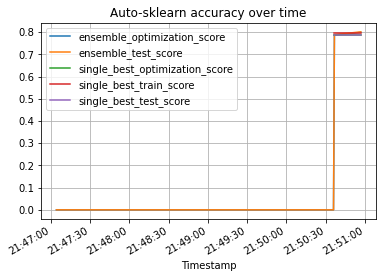

In [28]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print(automl.leaderboard())
poT = automl.performance_over_time_
print(poT)
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)

In [29]:
poT2 = poT 